<a href="https://colab.research.google.com/github/KenObata/TISMIR_notebooks/blob/main/week15_RoBERTa_baseline_keras_batch_layer_everywhere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week15: This notebook uses Pre-Trained RoBERTa

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://github.com/jasonwei20/eda_nlp


### set up

In [ ]:
!pip3 install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 8.6 MB/s 


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

def get_balanced_accuracy(model, McNemar, is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning):
  test_y = test.map(map_func_only_y)
  y_category=np.zeros((TEST_SIZE, ))
  counter=0
  for label_tensor in test_y.take(len(test_y)):
    y_test = np.argmax(label_tensor, axis=1)
    for label in y_test:
      y_category[counter]=label
      counter+=1

  X_test, y_test = test.map(map_func_only_X), y_category
  y_predict_test = np.asarray(model.predict(X_test))
  y_predict_test = np.argmax(y_predict_test, axis=1)
  print(classification_report(y_test, y_predict_test) )
  print(balanced_accuracy_score(y_test, y_predict_test))

  McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)] = []
  for ground_truh, pred in zip(y_test, y_predict_test):
        if ground_truh==pred:
          McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)].append(True)
        else:
          McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)].append(False)
  with open(DIR+ "RoBERTa_base_batch_normalize_everywhere_log.txt", "a") as f:
    print("======================================", file=f)
    print("is_fine_tuning?:", is_fine_tuning, "drop_out_rate: ", drop_out_rate, "learning_rate_transfer_learning: ", learning_rate_transfer_learning,
          "learning_rate_fine_tuning: ", learning_rate_fine_tuning, file=f)
    print(classification_report(y_test, y_predict_test) , file=f)
    print(balanced_accuracy_score(y_test, y_predict_test), file=f)

  return balanced_accuracy_score(y_test, y_predict_test), McNemar, y_predict_test

In [ ]:
#save output into text
DIR = '/content/drive/MyDrive/music4all/'
with open(DIR+ "RoBERTa_base_batch_normalize_everywhere_log.txt", "a") as f:
  print("File name: week15_RoBERTa_baseline_keras_batch_layer_everywhere.ipynb", file=f)


### Data Preparation(Kfold split)

Create dataframe for Gensim

In [ ]:
import pandas as pd

DIR = '/content/drive/MyDrive/music4all/'
df_genre_by_lang = pd.read_csv(DIR + 'df_genre_by_lang_full.csv')
df_genre_by_lang

,Unnamed: 0,id,genres,lang,lyric,number_of_line
0,0,0009fFIM1eYThaPg,pop,en,a sunny day so I got nowhere to hide Not a clo...,91
1,1,00P2bHdWFkghmDqz,soul,en,Tell me a tale that always was Sing me a song ...,36
2,2,00b6fV3nx5z2b8Ls,pop,en,A buh A buh You went to school to learn girl T...,74
3,3,013QDoTqbexEwkHr,pop,en,like a conversation where stops to breathe Is ...,20
4,4,01EKNot8qVgZpKM7,rock,en,Say the words I cannot say Say them on another...,31
...,...,...,...,...,...,...
13535,13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18
13536,13536,zzgS4ZqyswamEWNj,pop,en,Oh yeah yeah Last night I took a walk in the s...,75
13537,13537,zzx8CWdM7qkxKQpC,indie rock,en,Innocence it come easy in a sense it never wil...,34
13538,13538,zzz0n04uuTUA7fNh,pop,en,Girl you know how I feel I really Since you be...,65


In [ ]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [ ]:
data = load_data(df_genre_by_lang["lyric"], df_genre_by_lang["genres"])

In [ ]:
data

,texts,labels
0,"[a, sunny, day, so, I, got, nowhere, to, hide,...",pop
1,"[Tell, me, a, tale, that, always, was, Sing, m...",soul
2,"[A, buh, A, buh, You, went, to, school, to, le...",pop
3,"[like, a, conversation, where, stops, to, brea...",pop
4,"[Say, the, words, I, cannot, say, Say, them, o...",rock
...,...,...
13535,"[think, what, afraid, of, come, in, you, know,...",indie rock
13536,"[Oh, yeah, yeah, Last, night, I, took, a, walk...",pop
13537,"[Innocence, it, come, easy, in, a, sense, it, ...",indie rock
13538,"[Girl, you, know, how, I, feel, I, really, Sin...",pop


In [ ]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [ ]:
type(X)

pandas.core.series.Series

In [ ]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [ ]:
len(splits)

5

In [ ]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(10832,)
(10832,)
(2708,)
(2708,)


In [ ]:
split0['X_train']

0        [a, sunny, day, so, I, got, nowhere, to, hide,...
1        [Tell, me, a, tale, that, always, was, Sing, m...
3        [like, a, conversation, where, stops, to, brea...
6        [Locked, up, tight, Like, I, would, never, fee...
7        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
13534    [grandma, cookies, nigga, Shout, out, to, fron...
13536    [Oh, yeah, yeah, Last, night, I, took, a, walk...
13537    [Innocence, it, come, easy, in, a, sense, it, ...
13538    [Girl, you, know, how, I, feel, I, really, Sin...
13539    [wwI, oh, must, go, on, standing, You, break, ...
Name: texts, Length: 10832, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
3        4
6        4
7        6
        ..
13534    6
13536    4
13537    3
13538    4
13539    8
Name: labels, Length: 10832, dtype: int8

### Use my self programmed balanced accuracy

In [ ]:
metrics = Metrics()
history = model.fit(train, validation_data=val, epochs=10, class_weight=my_weight ,callbacks=[metrics])
metrics.get_data()

Epoch 1/10
339/339 [==============================] - 225s 645ms/step - loss: 0.5565 - categorical_accuracy: 0.3878 - val_loss: 1.9337 - val_categorical_accuracy: 0.3273
Epoch 2/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5397 - categorical_accuracy: 0.3626 - val_loss: 2.0651 - val_categorical_accuracy: 0.2764
Epoch 3/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5375 - categorical_accuracy: 0.3392 - val_loss: 2.0931 - val_categorical_accuracy: 0.2273
Epoch 4/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5378 - categorical_accuracy: 0.3197 - val_loss: 2.0576 - val_categorical_accuracy: 0.2459
Epoch 5/10
339/339 [==============================] - 219s 645ms/step - loss: 0.5333 - categorical_accuracy: 0.3077 - val_loss: 2.0292 - val_categorical_accuracy: 0.2816
Epoch 6/10
339/339 [==============================] - 219s 646ms/step - loss: 0.5373 - categorical_accuracy: 0.2967 - val_loss: 2.1738 - val_categoric

[{'balanced_accuracy': 0.09744849916749872},
 {'balanced_accuracy': 0.10420636932765996},
 {'balanced_accuracy': 0.10970405736872939},
 {'balanced_accuracy': 0.10356561320774078},
 {'balanced_accuracy': 0.10792864804613309},
 {'balanced_accuracy': 0.09168989857066105},
 {'balanced_accuracy': 0.09926135499834263},
 {'balanced_accuracy': 0.10014630125778516},
 {'balanced_accuracy': 0.09807505457274496},
 {'balanced_accuracy': 0.09881853716030842}]

## From here, separate X_train, X_test from KFOldSplit

### Preprocess my lyrics data (Official train and test)

In [ ]:
import tensorflow as tf
!pip3 install transformers
SEQ_LEN = 256#512

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 30.8 MB/s 
     |████████████████████████████████| 6.6 MB 63.3 MB/s 
     |████████████████████████████████| 120 kB 74.4 MB/s 


In [ ]:
split0['X_test']

2        [A, buh, A, buh, You, went, to, school, to, le...
4        [Say, the, words, I, cannot, say, Say, them, o...
5        [I, was, alone, I, was, made, of, stone, You, ...
9        [Again, the, burden, of, losing, rests, upon, ...
20       [only, been, three, weeks, And, a, bag, of, sp...
                               ...                        
13517    [Like, the, legend, of, the, Phoenix, All, end...
13522    [Mr, Telephone, man, something, wrong, with, m...
13526    [can, you, imagine, what, it, would, be, like,...
13532    [Love, of, my, life, hurt, me, broken, my, hea...
13535    [think, what, afraid, of, come, in, you, know,...
Name: texts, Length: 2708, dtype: object

In [ ]:
def prepare_lyrics(X_series):
  for i, token_list in X_series.items():
    if type(token_list) is list:
      X_series.loc[i] = ' '.join(token_list)
  return X_series

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
SEQ_LEN=256

def get_Xid_Xmask(X_origin):
  Xids_train = np.zeros((X_origin.shape[0], SEQ_LEN))
  Xmask_train = np.zeros((X_origin.shape[0], SEQ_LEN))

  for i, lyric in enumerate(X_origin):
    tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
    Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']
  return Xids_train, Xmask_train

In [ ]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask':masks}, labels

In [ ]:
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
#tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
Xids_train, Xmask_train = get_Xid_Xmask(split0['X_train'])
Xids_test, Xmask_test = get_Xid_Xmask(split0['X_test'])

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

dataset_train = dataset_train.shuffle(42).batch(16)
DS_LEN = len(list(dataset_train))
SPLIT=0.9
train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

In [ ]:
counter = Counter(split0['y_train'])
SUM=0
for item in list(counter.values()) :
  SUM+=item
#SUM = sum(counter.values())
SUM

10832

In [ ]:
#Tutorial
#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)

counter = Counter(split0['y_train'])
my_weight2 = {}
print(counter)

for genre in counter:
  #print(genre, counter[genre])
  my_weight2[genre] = (1/counter[genre]) * (SUM/10)
my_weight2

Counter({4: 4143, 7: 1159, 9: 1030, 3: 865, 6: 783, 0: 763, 1: 690, 8: 556, 2: 537, 5: 306})


{4: 0.2614530533429882,
 9: 1.051650485436893,
 6: 1.383397190293742,
 2: 2.0171322160148977,
 0: 1.4196592398427261,
 7: 0.9345987920621226,
 1: 1.569855072463768,
 5: 3.539869281045752,
 8: 1.948201438848921,
 3: 1.2522543352601156}

In [ ]:
TEST_SIZE = len(split0['X_test'])

In [ ]:
def map_func_only_X(val_dictionary, labels):
  return {'input_ids': val_dictionary['input_ids'], 'attention_mask':val_dictionary['attention_mask']}

In [ ]:
def map_func_only_y(val_dictionary, labels):
  return labels

### First Fold Do parameter tuning for dropout rate

I have intentionally separated cells for check point purpose, based on dropout rates

In [ ]:
McNemar={}

In [ ]:
del(model1)

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.2
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
    , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
    #step1
    roberta = TFAutoModel.from_pretrained('roberta-base')
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

    embeddings = roberta(input_ids, attention_mask= mask)[0]
    X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(128, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    X = tf.keras.layers.Dense(32, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

    model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    model1.layers[2].trainable = False
    #model2.summary()

    #step2
    optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
    #model2.summary() #Check trainable params increased.

    #step3: transfer learning
    print("Fine tuning---------------")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

    #step4: predict
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_transfer_learning.append( balanced_acc )

    #step5: fine tune
    model1.layers[2].trainable = True

    # It's important to recompile your model after you make any changes
    optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_fine_tuning.append( balanced_acc )
    print("----------------------------------------")
    del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 227ms/step - loss: 2.3285 - categorical_accuracy: 0.1999 - val_loss: 2.9120 - val_categorical_accuracy: 0.0754
Epoch 2/6
609/609 [==============================] - 135s 222ms/step - loss: 2.0351 - categorical_accuracy: 0.2519 - val_loss: 2.6977 - val_categorical_accuracy: 0.1167
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9705 - categorical_accuracy: 0.2658 - val_loss: 2.5980 - val_categorical_accuracy: 0.0873
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9290 - categorical_accuracy: 0.2831 - val_loss: 2.4370 - val_categorical_accuracy: 0.1278
Epoch 5/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9101 - categorical_accuracy: 0.2974 - val_loss: 2.2993 - val_categorical_accuracy: 0.1452
Epoch 6/6
609/609 [==============================] - 135s 222ms/step - loss: 1.8820 - categorical_accuracy: 0.2973 - val_loss: 2

609/609 [==============================] - 348s 545ms/step - loss: 1.8189 - categorical_accuracy: 0.3133 - val_loss: 2.0379 - val_categorical_accuracy: 0.2491
Epoch 2/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7199 - categorical_accuracy: 0.3390 - val_loss: 1.8195 - val_categorical_accuracy: 0.3704
Epoch 3/6
609/609 [==============================] - 329s 541ms/step - loss: 1.6424 - categorical_accuracy: 0.3606 - val_loss: 1.7757 - val_categorical_accuracy: 0.3557
Epoch 4/6
609/609 [==============================] - 330s 541ms/step - loss: 1.5682 - categorical_accuracy: 0.3830 - val_loss: 1.9617 - val_categorical_accuracy: 0.2822
Epoch 5/6
609/609 [==============================] - 330s 541ms/step - loss: 1.4806 - categorical_accuracy: 0.3981 - val_loss: 2.0354 - val_categorical_accuracy: 0.2537


TypeError: ignored

In [ ]:
balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )

              precision    recall  f1-score   support

         0.0       0.14      0.65      0.23       190
         1.0       0.20      0.50      0.28       173
         2.0       0.07      0.13      0.09       135
         3.0       0.17      0.11      0.13       216
         4.0       0.79      0.20      0.32      1036
         5.0       0.14      0.37      0.20        76
         6.0       0.76      0.77      0.77       195
         7.0       0.25      0.00      0.01       290
         8.0       0.15      0.14      0.14       139
         9.0       0.38      0.28      0.32       258

    accuracy                           0.27      2708
   macro avg       0.30      0.32      0.25      2708
weighted avg       0.47      0.27      0.27      2708

0.3151895200963239


In [ ]:
seen_parameter = []
seen_parameter.append((0.2, 1e-3, 1e-5))
seen_parameter

[(0.2, 0.001, 1e-05)]

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.2
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    if (drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning) not in seen_parameter:
      seen_parameter.append((drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning))
      print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
      , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
      #step1
      roberta = TFAutoModel.from_pretrained('roberta-base')
      input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
      mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

      embeddings = roberta(input_ids, attention_mask= mask)[0]
      X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
      X = tf.keras.layers.BatchNormalization()(X)
      X = tf.keras.layers.Dense(128, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      X = tf.keras.layers.Dense(32, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

      model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
      model1.layers[2].trainable = False
      #model2.summary()

      #step2
      optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
      #model2.summary() #Check trainable params increased.

      #step3: transfer learning
      print("Fine tuning---------------")
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

      #step4: predict
      balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_transfer_learning.append( balanced_acc )

      #step5: fine tune
      model1.layers[2].trainable = True

      # It's important to recompile your model after you make any changes
      optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
      balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_fine_tuning.append( balanced_acc )
      print("----------------------------------------")
      del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 227ms/step - loss: 2.3371 - categorical_accuracy: 0.1939 - val_loss: 3.1283 - val_categorical_accuracy: 0.0322
Epoch 2/6
609/609 [==============================] - 136s 223ms/step - loss: 2.0445 - categorical_accuracy: 0.2429 - val_loss: 2.6020 - val_categorical_accuracy: 0.1094
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9596 - categorical_accuracy: 0.2657 - val_loss: 2.4045 - val_categorical_accuracy: 0.1507
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9308 - categorical_accuracy: 0.2792 - val_loss: 2.3603 - val_categorical_accuracy: 0.1526
Epoch 5/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9047 - categorical_accuracy: 0.2794 - val_loss: 2.5446 - val_categorical_accuracy: 0.1333
Epoch 6/6
609/609 [==============================] - 135s 222ms/step - loss: 1.8828 - categorical_accuracy: 0.2918 - val_loss: 2

609/609 [==============================] - 348s 548ms/step - loss: 1.8170 - categorical_accuracy: 0.3156 - val_loss: 2.1809 - val_categorical_accuracy: 0.1949
Epoch 2/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7781 - categorical_accuracy: 0.3290 - val_loss: 2.0214 - val_categorical_accuracy: 0.2233
Epoch 3/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7638 - categorical_accuracy: 0.3297 - val_loss: 1.9729 - val_categorical_accuracy: 0.2408
Epoch 4/6
609/609 [==============================] - 329s 540ms/step - loss: 1.7324 - categorical_accuracy: 0.3327 - val_loss: 1.9742 - val_categorical_accuracy: 0.2417
Epoch 5/6
609/609 [==============================] - 329s 540ms/step - loss: 1.7191 - categorical_accuracy: 0.3461 - val_loss: 1.9634 - val_categorical_accuracy: 0.2472
Epoch 6/6
609/609 [==============================] - 329s 541ms/step - loss: 1.6922 - categorical_accuracy: 0.3446 - val_loss: 1.8795 - val_categorical_accuracy: 0.2

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 149s 225ms/step - loss: 2.7428 - categorical_accuracy: 0.1295 - val_loss: 3.1935 - val_categorical_accuracy: 0.0570
Epoch 2/6
609/609 [==============================] - 135s 221ms/step - loss: 2.4423 - categorical_accuracy: 0.1784 - val_loss: 3.1819 - val_categorical_accuracy: 0.0625
Epoch 3/6
609/609 [==============================] - 135s 221ms/step - loss: 2.3252 - categorical_accuracy: 0.1990 - val_loss: 3.2266 - val_categorical_accuracy: 0.0680
Epoch 4/6
609/609 [==============================] - 135s 221ms/step - loss: 2.2256 - categorical_accuracy: 0.2102 - val_loss: 3.1238 - val_categorical_accuracy: 0.0735
Epoch 5/6
609/609 [==============================] - 135s 221ms/step - loss: 2.1873 - categorical_accuracy: 0.2212 - val_loss: 2.9685 - val_categorical_accuracy: 0.0754
Epoch 6/6
609/609 [==============================] - 135s 221ms/step - loss: 2.1469 - categorical_accuracy: 0.2271 - val_loss: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 348s 545ms/step - loss: 2.0471 - categorical_accuracy: 0.2423 - val_loss: 2.5791 - val_categorical_accuracy: 0.1425
Epoch 2/6
609/609 [==============================] - 329s 540ms/step - loss: 1.9714 - categorical_accuracy: 0.2587 - val_loss: 2.2126 - val_categorical_accuracy: 0.2298
Epoch 3/6
609/609 [==============================] - 329s 540ms/step - loss: 1.9003 - categorical_accuracy: 0.2817 - val_loss: 2.1666 - val_categorical_accuracy: 0.2307
Epoch 4/6
609/609 [==============================] - 329s 540ms/step - loss: 1.8505 - categorical_accuracy: 0.2926 - val_loss: 2.3077 - val_categorical_accuracy: 0.1930
Epoch 5/6
609/609 [==============================] - 329s 540ms/step - loss: 1.8046 - categorical_accuracy: 0.3025 - val_loss: 2.0126 - val_categorical_accuracy: 0.2831
Epoch 6/6
609/609 [==============================] - 329s 540ms/step - loss: 1.7125 - categorical_accuracy: 0.3244 - val_loss: 1.9162 - val_categorical_accuracy: 0.2

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
131/609 [=====>........................] - ETA: 1:36 - loss: 3.0206 - categorical_accuracy: 0.1031

KeyboardInterrupt: ignored

In [ ]:
seen_parameter.remove((0.2, 0.0001, 1e-06))
seen_parameter

[(0.2, 0.001, 1e-05), (0.2, 0.001, 1e-06), (0.2, 0.0001, 1e-05)]

Resume from the last cell

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
#balanced_accuracies_transfer_learning = []
#balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.2
learning_rate_transfer_learnings = [1e-4]
learning_rate_fine_tunings = [1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    if (drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning) not in seen_parameter:
      seen_parameter.append((drop_out_rate, learning_rate_transfer_learning, learning_rate_fine_tuning))
      print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
      , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
      #step1
      roberta = TFAutoModel.from_pretrained('roberta-base')
      input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
      mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

      embeddings = roberta(input_ids, attention_mask= mask)[0]
      X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
      X = tf.keras.layers.BatchNormalization()(X)
      X = tf.keras.layers.Dense(128, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      X = tf.keras.layers.Dense(32, activation = 'relu')(X)
      X = tf.keras.layers.BatchNormalization()(X)#added
      X = tf.keras.layers.Dropout(drop_out_rate)(X)
      y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

      model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
      model1.layers[2].trainable = False
      #model2.summary()

      #step2
      optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
      #model2.summary() #Check trainable params increased.

      #step3: transfer learning
      print("Fine tuning---------------")
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

      #step4: predict
      balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_transfer_learning.append( balanced_acc )

      #step5: fine tune
      model1.layers[2].trainable = True

      # It's important to recompile your model after you make any changes
      optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
      loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
      metrics = []
      metrics.append(
          tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
      model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

      history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
      balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
      balanced_accuracies_fine_tuning.append( balanced_acc )
      print("----------------------------------------")
      del(model1)


learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.2


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 151s 227ms/step - loss: 2.7623 - categorical_accuracy: 0.1453 - val_loss: 3.1981 - val_categorical_accuracy: 0.0754
Epoch 2/6
609/609 [==============================] - 135s 222ms/step - loss: 2.4888 - categorical_accuracy: 0.1840 - val_loss: 3.1922 - val_categorical_accuracy: 0.0754
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 2.3380 - categorical_accuracy: 0.2008 - val_loss: 3.2587 - val_categorical_accuracy: 0.0616
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 2.2725 - categorical_accuracy: 0.2084 - val_loss: 3.1439 - val_categorical_accuracy: 0.0772
Epoch 5/6
609/609 [==============================] - 135s 222ms/step - loss: 2.1965 - categorical_accuracy: 0.2193 - val_loss: 3.0930 - val_categorical_accuracy: 0.0809
Epoch 6/6
609/609 [==============================] - 135s 222ms/step - loss: 2.1641 - categorical_accuracy: 0.2232 - val_loss: 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 347s 546ms/step - loss: 2.1121 - categorical_accuracy: 0.2336 - val_loss: 2.7923 - val_categorical_accuracy: 0.1048
Epoch 2/6
609/609 [==============================] - 330s 542ms/step - loss: 2.0635 - categorical_accuracy: 0.2377 - val_loss: 2.7294 - val_categorical_accuracy: 0.1186
Epoch 3/6
609/609 [==============================] - 330s 542ms/step - loss: 2.0396 - categorical_accuracy: 0.2493 - val_loss: 2.4700 - val_categorical_accuracy: 0.1728
Epoch 4/6
609/609 [==============================] - 330s 542ms/step - loss: 2.0244 - categorical_accuracy: 0.2553 - val_loss: 2.3056 - val_categorical_accuracy: 0.1994
Epoch 5/6
609/609 [==============================] - 330s 541ms/step - loss: 1.9860 - categorical_accuracy: 0.2595 - val_loss: 2.3044 - val_categorical_accuracy: 0.1967
Epoch 6/6
609/609 [==============================] - 330s 541ms/step - loss: 1.9462 - categorical_accuracy: 0.2628 - val_loss: 2.1698 - val_categorical_accuracy: 0.2

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
#balanced_accuracies_transfer_learning = []
#balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.3
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
    , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
    #step1
    roberta = TFAutoModel.from_pretrained('roberta-base')
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

    embeddings = roberta(input_ids, attention_mask= mask)[0]
    X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(128, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    X = tf.keras.layers.Dense(32, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

    model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    model1.layers[2].trainable = False
    #model2.summary()

    #step2
    optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
    #model2.summary() #Check trainable params increased.

    #step3: transfer learning
    print("Fine tuning---------------")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

    #step4: predict
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_transfer_learning.append( balanced_acc )

    #step5: fine tune
    model1.layers[2].trainable = True

    # It's important to recompile your model after you make any changes
    optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_fine_tuning.append( balanced_acc )
    print("----------------------------------------")
    del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 227ms/step - loss: 2.4073 - categorical_accuracy: 0.1969 - val_loss: 3.0823 - val_categorical_accuracy: 0.0404
Epoch 2/6
609/609 [==============================] - 135s 222ms/step - loss: 2.0965 - categorical_accuracy: 0.2379 - val_loss: 2.8630 - val_categorical_accuracy: 0.0487
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9912 - categorical_accuracy: 0.2639 - val_loss: 2.7638 - val_categorical_accuracy: 0.1241
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9680 - categorical_accuracy: 0.2728 - val_loss: 2.3903 - val_categorical_accuracy: 0.1324
Epoch 5/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9262 - categorical_accuracy: 0.2869 - val_loss: 2.2126 - val_categorical_accuracy: 0.1673
Epoch 6/6
609/609 [==============================] - ETA: 0s - loss: 1.9210 - categorical_accuracy: 0.2921              precisio

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 348s 546ms/step - loss: 1.8392 - categorical_accuracy: 0.3012 - val_loss: 2.0303 - val_categorical_accuracy: 0.2178
Epoch 2/6
609/609 [==============================] - 330s 541ms/step - loss: 1.7678 - categorical_accuracy: 0.3251 - val_loss: 1.9737 - val_categorical_accuracy: 0.2362
Epoch 3/6
609/609 [==============================] - 330s 541ms/step - loss: 1.6921 - categorical_accuracy: 0.3348 - val_loss: 1.9972 - val_categorical_accuracy: 0.2417
Epoch 4/6
609/609 [==============================] - 330s 541ms/step - loss: 1.6408 - categorical_accuracy: 0.3487 - val_loss: 1.9339 - val_categorical_accuracy: 0.2748
Epoch 5/6
609/609 [==============================] - 330s 542ms/step - loss: 1.5870 - categorical_accuracy: 0.3615 - val_loss: 2.0351 - val_categorical_accuracy: 0.2215
Epoch 6/6
609/609 [==============================] - 330s 542ms/step - loss: 1.5200 - categorical_accuracy: 0.3781 - val_loss: 1.8601 - val_categorical_accuracy: 0.2

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 228ms/step - loss: 2.4026 - categorical_accuracy: 0.1914 - val_loss: 2.8984 - val_categorical_accuracy: 0.0478
Epoch 2/6
609/609 [==============================] - 135s 222ms/step - loss: 2.0880 - categorical_accuracy: 0.2303 - val_loss: 2.4334 - val_categorical_accuracy: 0.1535
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 2.0128 - categorical_accuracy: 0.2504 - val_loss: 2.6119 - val_categorical_accuracy: 0.1103
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9649 - categorical_accuracy: 0.2674 - val_loss: 2.4950 - val_categorical_accuracy: 0.1002
Epoch 5/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9443 - categorical_accuracy: 0.2749 - val_loss: 2.5234 - val_categorical_accuracy: 0.0938
              precision    recall  f1-score   support

         0.0       0.09      0.37      0.15       190
         1.0       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 347s 545ms/step - loss: 1.8728 - categorical_accuracy: 0.2870 - val_loss: 2.2280 - val_categorical_accuracy: 0.1654
Epoch 2/6
609/609 [==============================] - 329s 541ms/step - loss: 1.8347 - categorical_accuracy: 0.3010 - val_loss: 2.1238 - val_categorical_accuracy: 0.1976
Epoch 3/6
609/609 [==============================] - 329s 541ms/step - loss: 1.8135 - categorical_accuracy: 0.3043 - val_loss: 2.1192 - val_categorical_accuracy: 0.2013
Epoch 4/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7961 - categorical_accuracy: 0.3051 - val_loss: 2.0223 - val_categorical_accuracy: 0.2298
Epoch 5/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7830 - categorical_accuracy: 0.3130 - val_loss: 2.0318 - val_categorical_accuracy: 0.2233
Epoch 6/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7604 - categorical_accuracy: 0.3198 - val_loss: 1.9851 - val_categorical_accuracy: 0.2

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 149s 226ms/step - loss: 2.8897 - categorical_accuracy: 0.1229 - val_loss: 2.8248 - val_categorical_accuracy: 0.0680
Epoch 2/6
609/609 [==============================] - 135s 222ms/step - loss: 2.5948 - categorical_accuracy: 0.1588 - val_loss: 2.8157 - val_categorical_accuracy: 0.0882
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 2.4483 - categorical_accuracy: 0.1765 - val_loss: 2.8907 - val_categorical_accuracy: 0.0699
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 2.3687 - categorical_accuracy: 0.1788 - val_loss: 2.8541 - val_categorical_accuracy: 0.0699
Epoch 5/6
609/609 [==============================] - 135s 222ms/step - loss: 2.2732 - categorical_accuracy: 0.1957 - val_loss: 2.7726 - val_categorical_accuracy: 0.0836
              precision    recall  f1-score   support

         0.0       0.10      0.42      0.16       190
         1.0       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 348s 545ms/step - loss: 2.1876 - categorical_accuracy: 0.2122 - val_loss: 2.8993 - val_categorical_accuracy: 0.0818
Epoch 2/6
609/609 [==============================] - 329s 541ms/step - loss: 2.0999 - categorical_accuracy: 0.2242 - val_loss: 2.2868 - val_categorical_accuracy: 0.1710
Epoch 3/6
609/609 [==============================] - 329s 541ms/step - loss: 2.0557 - categorical_accuracy: 0.2432 - val_loss: 2.2392 - val_categorical_accuracy: 0.2096
Epoch 4/6
609/609 [==============================] - 329s 541ms/step - loss: 1.9977 - categorical_accuracy: 0.2617 - val_loss: 2.4664 - val_categorical_accuracy: 0.1562
Epoch 5/6
609/609 [==============================] - 329s 541ms/step - loss: 1.9476 - categorical_accuracy: 0.2694 - val_loss: 2.2084 - val_categorical_accuracy: 0.1921
Epoch 6/6
609/609 [==============================] - 329s 541ms/step - loss: 1.9087 - categorical_accuracy: 0.2875 - val_loss: 2.4074 - val_categorical_accuracy: 0.1

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 149s 226ms/step - loss: 2.9341 - categorical_accuracy: 0.1148 - val_loss: 2.7935 - val_categorical_accuracy: 0.0846
Epoch 2/6
609/609 [==============================] - 135s 222ms/step - loss: 2.6026 - categorical_accuracy: 0.1650 - val_loss: 2.8363 - val_categorical_accuracy: 0.0662
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 2.4459 - categorical_accuracy: 0.1785 - val_loss: 2.7896 - val_categorical_accuracy: 0.0699
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 2.3527 - categorical_accuracy: 0.1880 - val_loss: 2.7363 - val_categorical_accuracy: 0.0772
              precision    recall  f1-score   support

         0.0       0.10      0.36      0.15       190
         1.0       0.05      0.03      0.04       173
         2.0       0.03      0.03      0.03       135
         3.0       0.10      0.16      0.12       216
         4.0       0.00   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 348s 545ms/step - loss: 2.2656 - categorical_accuracy: 0.2049 - val_loss: 2.6151 - val_categorical_accuracy: 0.1057
Epoch 2/6
609/609 [==============================] - 329s 541ms/step - loss: 2.2263 - categorical_accuracy: 0.2140 - val_loss: 2.5356 - val_categorical_accuracy: 0.1268
Epoch 3/6
609/609 [==============================] - 329s 541ms/step - loss: 2.1914 - categorical_accuracy: 0.2167 - val_loss: 2.4755 - val_categorical_accuracy: 0.1369
Epoch 4/6
609/609 [==============================] - 329s 541ms/step - loss: 2.1559 - categorical_accuracy: 0.2253 - val_loss: 2.3750 - val_categorical_accuracy: 0.1654
Epoch 5/6
609/609 [==============================] - 329s 541ms/step - loss: 2.1523 - categorical_accuracy: 0.2256 - val_loss: 2.3370 - val_categorical_accuracy: 0.1783
Epoch 6/6
609/609 [==============================] - 329s 541ms/step - loss: 2.0898 - categorical_accuracy: 0.2428 - val_loss: 2.3126 - val_categorical_accuracy: 0.1

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.4
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
    , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
    #step1
    roberta = TFAutoModel.from_pretrained('roberta-base')
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

    embeddings = roberta(input_ids, attention_mask= mask)[0]
    X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(128, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    X = tf.keras.layers.Dense(32, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

    model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    model1.layers[2].trainable = False
    #model2.summary()

    #step2
    optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
    #model2.summary() #Check trainable params increased.

    #step3: transfer learning
    print("Fine tuning---------------")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

    #step4: predict
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_transfer_learning.append( balanced_acc )

    #step5: fine tune
    model1.layers[2].trainable = True

    # It's important to recompile your model after you make any changes
    optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_fine_tuning.append( balanced_acc )
    print("----------------------------------------")
    del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.4


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 149s 226ms/step - loss: 2.4542 - categorical_accuracy: 0.1899 - val_loss: 2.8151 - val_categorical_accuracy: 0.0634
Epoch 2/6
609/609 [==============================] - 135s 222ms/step - loss: 2.1310 - categorical_accuracy: 0.2188 - val_loss: 2.4666 - val_categorical_accuracy: 0.1268
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 2.0226 - categorical_accuracy: 0.2452 - val_loss: 2.4471 - val_categorical_accuracy: 0.0818
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9892 - categorical_accuracy: 0.2645 - val_loss: 2.3568 - val_categorical_accuracy: 0.1029
Epoch 5/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9626 - categorical_accuracy: 0.2672 - val_loss: 2.2627 - val_categorical_accuracy: 0.1544
Epoch 6/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9395 - categorical_accuracy: 0.2821 - val_loss: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 348s 545ms/step - loss: 1.8756 - categorical_accuracy: 0.3091 - val_loss: 1.9463 - val_categorical_accuracy: 0.2482
Epoch 2/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7993 - categorical_accuracy: 0.3176 - val_loss: 1.7884 - val_categorical_accuracy: 0.3272
Epoch 3/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7417 - categorical_accuracy: 0.3284 - val_loss: 1.9915 - val_categorical_accuracy: 0.2693
Epoch 4/6
609/609 [==============================] - 329s 540ms/step - loss: 1.6914 - categorical_accuracy: 0.3426 - val_loss: 1.9997 - val_categorical_accuracy: 0.2362
Epoch 5/6
609/609 [==============================] - 329s 541ms/step - loss: 1.6447 - categorical_accuracy: 0.3515 - val_loss: 1.9781 - val_categorical_accuracy: 0.2564
              precision    recall  f1-score   support

         0.0       0.23      0.32      0.26       190
         1.0       0.23      0.51      0.31       173
  

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 149s 226ms/step - loss: 2.4749 - categorical_accuracy: 0.1754 - val_loss: 2.6191 - val_categorical_accuracy: 0.1121
Epoch 2/6
609/609 [==============================] - 135s 221ms/step - loss: 2.1026 - categorical_accuracy: 0.2251 - val_loss: 2.6202 - val_categorical_accuracy: 0.0818
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 2.0197 - categorical_accuracy: 0.2505 - val_loss: 2.4863 - val_categorical_accuracy: 0.1140
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9856 - categorical_accuracy: 0.2665 - val_loss: 2.4909 - val_categorical_accuracy: 0.1186
Epoch 5/6
609/609 [==============================] - 135s 221ms/step - loss: 1.9547 - categorical_accuracy: 0.2716 - val_loss: 2.2925 - val_categorical_accuracy: 0.1673
Epoch 6/6
609/609 [==============================] - 135s 222ms/step - loss: 1.9430 - categorical_accuracy: 0.2683 - val_loss: 2

609/609 [==============================] - 348s 545ms/step - loss: 1.8970 - categorical_accuracy: 0.2833 - val_loss: 2.1194 - val_categorical_accuracy: 0.1949
Epoch 2/6
609/609 [==============================] - 329s 540ms/step - loss: 1.8506 - categorical_accuracy: 0.2992 - val_loss: 2.0665 - val_categorical_accuracy: 0.2188
Epoch 3/6
609/609 [==============================] - 329s 540ms/step - loss: 1.8405 - categorical_accuracy: 0.2991 - val_loss: 2.0151 - val_categorical_accuracy: 0.2215
Epoch 4/6
609/609 [==============================] - 329s 540ms/step - loss: 1.8120 - categorical_accuracy: 0.3077 - val_loss: 1.9574 - val_categorical_accuracy: 0.2472
Epoch 5/6
609/609 [==============================] - 329s 541ms/step - loss: 1.8060 - categorical_accuracy: 0.3041 - val_loss: 1.9707 - val_categorical_accuracy: 0.2491
Epoch 6/6
609/609 [==============================] - 329s 541ms/step - loss: 1.7840 - categorical_accuracy: 0.3111 - val_loss: 1.9827 - val_categorical_accuracy: 0.2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.17      0.34      0.23       190
         1.0       0.19      0.61      0.29       173
         2.0       0.04      0.02      0.03       135
         3.0       0.20      0.19      0.19       216
         4.0       0.76      0.09      0.16      1036
         5.0       0.12      0.66      0.21        76
         6.0       0.60      0.84      0.70       195
         7.0       0.00      0.00      0.00       290
         8.0       0.04      0.02      0.03       139
         9.0       0.21      0.51      0.30       258

    accuracy                           0.24      2708
   macro avg       0.23      0.33      0.21      2708
weighted avg       0.40      0.24      0.20      2708

0.3276436556673048
----------------------------------------
learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.4


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 149s 226ms/step - loss: 3.0280 - categorical_accuracy: 0.1227 - val_loss: 2.9578 - val_categorical_accuracy: 0.0928
Epoch 2/6
609/609 [==============================] - 135s 222ms/step - loss: 2.7454 - categorical_accuracy: 0.1631 - val_loss: 3.0110 - val_categorical_accuracy: 0.0836
Epoch 3/6
609/609 [==============================] - 135s 222ms/step - loss: 2.5891 - categorical_accuracy: 0.1770 - val_loss: 2.9322 - val_categorical_accuracy: 0.0653
Epoch 4/6
609/609 [==============================] - 135s 222ms/step - loss: 2.4608 - categorical_accuracy: 0.1872 - val_loss: 2.8264 - val_categorical_accuracy: 0.0910


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.08      0.36      0.13       190
         1.0       0.09      0.48      0.15       173
         2.0       0.08      0.01      0.01       135
         3.0       0.05      0.03      0.04       216
         4.0       0.00      0.00      0.00      1036
         5.0       0.05      0.28      0.08        76
         6.0       0.88      0.14      0.25       195
         7.0       0.09      0.07      0.08       290
         8.0       0.00      0.00      0.00       139
         9.0       0.00      0.00      0.00       258

    accuracy                           0.08      2708
   macro avg       0.13      0.14      0.07      2708
weighted avg       0.09      0.08      0.05      2708

0.1366982916354002
Epoch 1/6


609/609 [==============================] - 348s 546ms/step - loss: 2.3335 - categorical_accuracy: 0.2008 - val_loss: 2.4296 - val_categorical_accuracy: 0.1544
Epoch 2/6
609/609 [==============================] - 330s 541ms/step - loss: 2.2672 - categorical_accuracy: 0.2134 - val_loss: 2.2341 - val_categorical_accuracy: 0.1875
Epoch 3/6
609/609 [==============================] - 330s 541ms/step - loss: 2.2391 - categorical_accuracy: 0.2120 - val_loss: 2.6119 - val_categorical_accuracy: 0.1765
Epoch 4/6
609/609 [==============================] - 330s 541ms/step - loss: 2.1688 - categorical_accuracy: 0.2368 - val_loss: 2.6012 - val_categorical_accuracy: 0.1562
Epoch 5/6
609/609 [==============================] - 330s 541ms/step - loss: 2.1187 - categorical_accuracy: 0.2362 - val_loss: 2.2356 - val_categorical_accuracy: 0.2086
Epoch 6/6
609/609 [==============================] - 330s 541ms/step - loss: 2.0769 - categorical_accuracy: 0.2465 - val_loss: 2.5999 - val_categorical_accuracy: 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.06      0.16      0.09       190
         1.0       0.18      0.31      0.23       173
         2.0       0.08      0.21      0.12       135
         3.0       0.08      0.10      0.09       216
         4.0       0.00      0.00      0.00      1036
         5.0       0.07      0.62      0.13        76
         6.0       0.75      0.76      0.76       195
         7.0       0.13      0.04      0.06       290
         8.0       0.13      0.01      0.03       139
         9.0       0.23      0.31      0.26       258

    accuracy                           0.16      2708
   macro avg       0.17      0.25      0.18      2708
weighted avg       0.13      0.16      0.13      2708

0.25364562564024085
----------------------------------------
learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.4


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 227ms/step - loss: 3.0524 - categorical_accuracy: 0.1129 - val_loss: 2.9196 - val_categorical_accuracy: 0.0735
Epoch 2/6
609/609 [==============================] - 136s 223ms/step - loss: 2.7968 - categorical_accuracy: 0.1471 - val_loss: 2.8759 - val_categorical_accuracy: 0.1002
Epoch 3/6
609/609 [==============================] - 136s 223ms/step - loss: 2.5970 - categorical_accuracy: 0.1715 - val_loss: 2.8094 - val_categorical_accuracy: 0.0928
Epoch 4/6
609/609 [==============================] - 136s 223ms/step - loss: 2.4764 - categorical_accuracy: 0.1701 - val_loss: 2.7641 - val_categorical_accuracy: 0.0855
Epoch 5/6
609/609 [==============================] - 136s 223ms/step - loss: 2.4143 - categorical_accuracy: 0.1790 - val_loss: 2.6129 - val_categorical_accuracy: 0.0892
              precision    recall  f1-score   support

         0.0       0.07      0.18      0.10       190
         1.0       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 348s 546ms/step - loss: 2.3559 - categorical_accuracy: 0.1822 - val_loss: 2.5259 - val_categorical_accuracy: 0.1103
Epoch 2/6
609/609 [==============================] - 330s 541ms/step - loss: 2.3164 - categorical_accuracy: 0.1894 - val_loss: 2.4172 - val_categorical_accuracy: 0.1241
Epoch 3/6
609/609 [==============================] - 330s 541ms/step - loss: 2.2865 - categorical_accuracy: 0.1998 - val_loss: 2.3814 - val_categorical_accuracy: 0.1443
Epoch 4/6
609/609 [==============================] - 329s 541ms/step - loss: 2.2282 - categorical_accuracy: 0.2037 - val_loss: 2.3062 - val_categorical_accuracy: 0.1682
Epoch 5/6
609/609 [==============================] - 330s 541ms/step - loss: 2.2059 - categorical_accuracy: 0.2067 - val_loss: 2.2711 - val_categorical_accuracy: 0.1792
Epoch 6/6
609/609 [==============================] - 330s 541ms/step - loss: 2.2220 - categorical_accuracy: 0.2075 - val_loss: 2.2184 - val_categorical_accuracy: 0.1

In [ ]:
from transformers import TFAutoModel


#drop_out_rates = [0.1, 0.2, 0.3,0.4, 0.5]
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []
SEQ_LEN2=256
#for drop_out_rate in drop_out_rates:

drop_out_rate = 0.5
learning_rate_transfer_learnings = [1e-3, 1e-4]
learning_rate_fine_tunings = [1e-5, 1e-6]

for learning_rate_transfer_learning in learning_rate_transfer_learnings:
  for learning_rate_fine_tuning in learning_rate_fine_tunings:
    print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
    , learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
    #step1
    roberta = TFAutoModel.from_pretrained('roberta-base')
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

    embeddings = roberta(input_ids, attention_mask= mask)[0]
    X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(128, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    X = tf.keras.layers.Dense(32, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)#added
    X = tf.keras.layers.Dropout(drop_out_rate)(X)
    y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

    model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
    model1.layers[2].trainable = False
    #model2.summary()

    #step2
    optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
    #model2.summary() #Check trainable params increased.

    #step3: transfer learning
    print("Fine tuning---------------")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

    #step4: predict
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_transfer_learning.append( balanced_acc )

    #step5: fine tune
    model1.layers[2].trainable = True

    # It's important to recompile your model after you make any changes
    optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
    metrics = []
    metrics.append(
        tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
    model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

    history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
    balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
    balanced_accuracies_fine_tuning.append( balanced_acc )
    print("----------------------------------------")
    del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.5


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 228ms/step - loss: 2.5723 - categorical_accuracy: 0.1706 - val_loss: 2.7886 - val_categorical_accuracy: 0.0533
Epoch 2/6
609/609 [==============================] - 136s 223ms/step - loss: 2.1607 - categorical_accuracy: 0.2142 - val_loss: 2.7125 - val_categorical_accuracy: 0.0892
Epoch 3/6
609/609 [==============================] - 136s 223ms/step - loss: 2.0655 - categorical_accuracy: 0.2433 - val_loss: 2.5005 - val_categorical_accuracy: 0.1241
Epoch 4/6
609/609 [==============================] - 136s 223ms/step - loss: 2.0219 - categorical_accuracy: 0.2607 - val_loss: 2.4837 - val_categorical_accuracy: 0.1140
Epoch 5/6
609/609 [==============================] - 136s 223ms/step - loss: 1.9900 - categorical_accuracy: 0.2599 - val_loss: 2.2952 - val_categorical_accuracy: 0.1406
Epoch 6/6
609/609 [==============================] - 136s 223ms/step - loss: 1.9791 - categorical_accuracy: 0.2643 - val_loss: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 349s 546ms/step - loss: 1.9179 - categorical_accuracy: 0.2849 - val_loss: 2.0470 - val_categorical_accuracy: 0.2868
Epoch 2/6
609/609 [==============================] - 330s 542ms/step - loss: 1.8550 - categorical_accuracy: 0.3072 - val_loss: 1.8726 - val_categorical_accuracy: 0.2270
Epoch 3/6
609/609 [==============================] - 330s 542ms/step - loss: 1.8102 - categorical_accuracy: 0.3170 - val_loss: 1.8666 - val_categorical_accuracy: 0.2353
Epoch 4/6
609/609 [==============================] - 330s 542ms/step - loss: 1.7610 - categorical_accuracy: 0.3277 - val_loss: 1.8358 - val_categorical_accuracy: 0.3217
Epoch 5/6
609/609 [==============================] - 330s 542ms/step - loss: 1.7284 - categorical_accuracy: 0.3365 - val_loss: 1.8808 - val_categorical_accuracy: 0.2353
Epoch 6/6
609/609 [==============================] - 330s 542ms/step - loss: 1.6740 - categorical_accuracy: 0.3514 - val_loss: 1.8696 - val_categorical_accuracy: 0.2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.16      0.33      0.22       190
         1.0       0.17      0.71      0.27       173
         2.0       0.00      0.00      0.00       135
         3.0       0.20      0.21      0.21       216
         4.0       0.70      0.17      0.27      1036
         5.0       0.36      0.28      0.31        76
         6.0       0.80      0.82      0.81       195
         7.0       0.00      0.00      0.00       290
         8.0       0.09      0.05      0.06       139
         9.0       0.22      0.65      0.33       258

    accuracy                           0.28      2708
   macro avg       0.27      0.32      0.25      2708
weighted avg       0.40      0.28      0.26      2708

0.3223759852089486
----------------------------------------
learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.5


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 227ms/step - loss: 2.6076 - categorical_accuracy: 0.1757 - val_loss: 2.7822 - val_categorical_accuracy: 0.0965
Epoch 2/6
609/609 [==============================] - 136s 223ms/step - loss: 2.1624 - categorical_accuracy: 0.2118 - val_loss: 2.7191 - val_categorical_accuracy: 0.0818
Epoch 3/6
609/609 [==============================] - 136s 223ms/step - loss: 2.0651 - categorical_accuracy: 0.2255 - val_loss: 2.4525 - val_categorical_accuracy: 0.1112
Epoch 4/6
609/609 [==============================] - 136s 223ms/step - loss: 2.0330 - categorical_accuracy: 0.2487 - val_loss: 2.3860 - val_categorical_accuracy: 0.1241
Epoch 5/6
609/609 [==============================] - 136s 223ms/step - loss: 1.9939 - categorical_accuracy: 0.2625 - val_loss: 2.3762 - val_categorical_accuracy: 0.1324
Epoch 6/6
609/609 [==============================] - 136s 223ms/step - loss: 1.9846 - categorical_accuracy: 0.2690 - val_loss: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 351s 546ms/step - loss: 1.9483 - categorical_accuracy: 0.2763 - val_loss: 2.2453 - val_categorical_accuracy: 0.1535
Epoch 2/6
609/609 [==============================] - 330s 542ms/step - loss: 1.9052 - categorical_accuracy: 0.2805 - val_loss: 2.1403 - val_categorical_accuracy: 0.1728
Epoch 3/6
609/609 [==============================] - 330s 542ms/step - loss: 1.8906 - categorical_accuracy: 0.2830 - val_loss: 2.0559 - val_categorical_accuracy: 0.2004
Epoch 4/6
609/609 [==============================] - 330s 542ms/step - loss: 1.8676 - categorical_accuracy: 0.2950 - val_loss: 1.9908 - val_categorical_accuracy: 0.2233
Epoch 5/6
609/609 [==============================] - 330s 542ms/step - loss: 1.8608 - categorical_accuracy: 0.2923 - val_loss: 1.9584 - val_categorical_accuracy: 0.2362
Epoch 6/6
609/609 [==============================] - 330s 542ms/step - loss: 1.8445 - categorical_accuracy: 0.2939 - val_loss: 1.9489 - val_categorical_accuracy: 0.2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.18      0.21      0.20       190
         1.0       0.19      0.51      0.28       173
         2.0       0.13      0.11      0.12       135
         3.0       0.25      0.06      0.10       216
         4.0       0.74      0.12      0.21      1036
         5.0       0.10      0.68      0.17        76
         6.0       0.62      0.85      0.71       195
         7.0       0.00      0.00      0.00       290
         8.0       0.09      0.13      0.11       139
         9.0       0.21      0.56      0.31       258

    accuracy                           0.24      2708
   macro avg       0.25      0.32      0.22      2708
weighted avg       0.40      0.24      0.22      2708

0.32434357586470963
----------------------------------------
learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.5


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 228ms/step - loss: 3.2554 - categorical_accuracy: 0.1170 - val_loss: 3.0332 - val_categorical_accuracy: 0.0579
Epoch 2/6
609/609 [==============================] - 136s 223ms/step - loss: 2.9029 - categorical_accuracy: 0.1468 - val_loss: 3.2806 - val_categorical_accuracy: 0.0579
Epoch 3/6
609/609 [==============================] - 136s 223ms/step - loss: 2.7561 - categorical_accuracy: 0.1536 - val_loss: 3.2659 - val_categorical_accuracy: 0.0588
Epoch 4/6
609/609 [==============================] - 136s 223ms/step - loss: 2.5780 - categorical_accuracy: 0.1672 - val_loss: 3.1969 - val_categorical_accuracy: 0.0607
Epoch 5/6
609/609 [==============================] - 136s 223ms/step - loss: 2.5051 - categorical_accuracy: 0.1727 - val_loss: 3.1199 - val_categorical_accuracy: 0.0542
Epoch 6/6
609/609 [==============================] - 136s 223ms/step - loss: 2.4622 - categorical_accuracy: 0.1790 - val_loss: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 350s 547ms/step - loss: 2.3318 - categorical_accuracy: 0.1931 - val_loss: 3.2783 - val_categorical_accuracy: 0.0855
Epoch 2/6
609/609 [==============================] - 330s 542ms/step - loss: 2.2534 - categorical_accuracy: 0.2079 - val_loss: 3.0881 - val_categorical_accuracy: 0.1057
Epoch 3/6
609/609 [==============================] - 330s 542ms/step - loss: 2.1891 - categorical_accuracy: 0.2308 - val_loss: 2.8388 - val_categorical_accuracy: 0.1636
Epoch 4/6
609/609 [==============================] - 330s 542ms/step - loss: 2.1439 - categorical_accuracy: 0.2316 - val_loss: 4.1541 - val_categorical_accuracy: 0.1590
Epoch 5/6
609/609 [==============================] - 330s 542ms/step - loss: 2.1262 - categorical_accuracy: 0.2283 - val_loss: 4.9407 - val_categorical_accuracy: 0.0928
Epoch 6/6
609/609 [==============================] - 330s 542ms/step - loss: 2.0659 - categorical_accuracy: 0.2385 - val_loss: 3.5394 - val_categorical_accuracy: 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       190
         1.0       0.00      0.00      0.00       173
         2.0       0.05      0.44      0.09       135
         3.0       0.05      0.00      0.01       216
         4.0       0.00      0.00      0.00      1036
         5.0       0.19      0.33      0.24        76
         6.0       0.84      0.68      0.75       195
         7.0       0.14      0.32      0.19       290
         8.0       0.13      0.42      0.20       139
         9.0       0.34      0.07      0.12       258

    accuracy                           0.14      2708
   macro avg       0.17      0.23      0.16      2708
weighted avg       0.13      0.14      0.11      2708

0.2270289741235938
----------------------------------------
learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.5


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 150s 227ms/step - loss: 3.2578 - categorical_accuracy: 0.1333 - val_loss: 2.7400 - val_categorical_accuracy: 0.0772
Epoch 2/6
609/609 [==============================] - 136s 223ms/step - loss: 2.9365 - categorical_accuracy: 0.1563 - val_loss: 2.6826 - val_categorical_accuracy: 0.0827
Epoch 3/6
609/609 [==============================] - 136s 223ms/step - loss: 2.7347 - categorical_accuracy: 0.1643 - val_loss: 2.6823 - val_categorical_accuracy: 0.0818
Epoch 4/6
609/609 [==============================] - 136s 223ms/step - loss: 2.6142 - categorical_accuracy: 0.1791 - val_loss: 2.6662 - val_categorical_accuracy: 0.0597
Epoch 5/6
609/609 [==============================] - 136s 223ms/step - loss: 2.4990 - categorical_accuracy: 0.1832 - val_loss: 2.6509 - val_categorical_accuracy: 0.0607
              precision    recall  f1-score   support

         0.0       0.33      0.01      0.01       190
         1.0       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 350s 547ms/step - loss: 2.4422 - categorical_accuracy: 0.1880 - val_loss: 2.5606 - val_categorical_accuracy: 0.0836
Epoch 2/6
609/609 [==============================] - 330s 542ms/step - loss: 2.3977 - categorical_accuracy: 0.1929 - val_loss: 2.4574 - val_categorical_accuracy: 0.1048
Epoch 3/6
609/609 [==============================] - 330s 542ms/step - loss: 2.3883 - categorical_accuracy: 0.1948 - val_loss: 2.3974 - val_categorical_accuracy: 0.1186
Epoch 4/6
609/609 [==============================] - 330s 542ms/step - loss: 2.3338 - categorical_accuracy: 0.2124 - val_loss: 2.3656 - val_categorical_accuracy: 0.1250
Epoch 5/6
609/609 [==============================] - 330s 541ms/step - loss: 2.3128 - categorical_accuracy: 0.2071 - val_loss: 2.2800 - val_categorical_accuracy: 0.1599
Epoch 6/6
609/609 [==============================] - 330s 542ms/step - loss: 2.3064 - categorical_accuracy: 0.2139 - val_loss: 2.1883 - val_categorical_accuracy: 0.1

Best parameter is dropout=0.3, 1e-3, 1e-5

### KFold test

Best parameter is dropout=0.3, 1e-3, 1e-5

In [ ]:
del(dataset_train)
del(dataset_test)
del(train)
del(val)
del(test)

#### Fold1: intentionally separate cells for check point purpose.

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[1]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(10832,) (2708,)
Xids_train.shape, Xids_test.shape:  (10832, 256) (2708, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
McNemar={}
balanced_accuracies_transfer_learning = []
balanced_accuracies_fine_tuning = []

In [ ]:
TEST_SIZE

2708

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 97s 137ms/step - loss: 2.4171 - categorical_accuracy: 0.1856 - val_loss: 2.8856 - val_categorical_accuracy: 0.0570
Epoch 2/6
609/609 [==============================] - 80s 132ms/step - loss: 2.0957 - categorical_accuracy: 0.2345 - val_loss: 2.8266 - val_categorical_accuracy: 0.0340
Epoch 3/6
609/609 [==============================] - 80s 131ms/step - loss: 2.0060 - categorical_accuracy: 0.2544 - val_loss: 2.5190 - val_categorical_accuracy: 0.0809
Epoch 4/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9643 - categorical_accuracy: 0.2758 - val_loss: 2.5540 - val_categorical_accuracy: 0.0653
Epoch 5/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9407 - categorical_accuracy: 0.2796 - val_loss: 2.3647 - val_categorical_accuracy: 0.1278
Epoch 6/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9200 - categorical_accuracy: 0.2896 - val_loss: 2.2885 

609/609 [==============================] - 206s 312ms/step - loss: 1.8452 - categorical_accuracy: 0.2963 - val_loss: 2.0276 - val_categorical_accuracy: 0.2656
Epoch 2/6
609/609 [==============================] - 187s 307ms/step - loss: 1.7783 - categorical_accuracy: 0.3177 - val_loss: 1.7496 - val_categorical_accuracy: 0.3906
Epoch 3/6
609/609 [==============================] - 187s 307ms/step - loss: 1.7207 - categorical_accuracy: 0.3305 - val_loss: 1.8328 - val_categorical_accuracy: 0.2941
Epoch 4/6
609/609 [==============================] - 187s 307ms/step - loss: 1.6763 - categorical_accuracy: 0.3439 - val_loss: 1.9388 - val_categorical_accuracy: 0.2463
Epoch 5/6
609/609 [==============================] - 187s 307ms/step - loss: 1.6482 - categorical_accuracy: 0.3518 - val_loss: 1.7410 - val_categorical_accuracy: 0.3851
              precision    recall  f1-score   support

         0.0       0.18      0.21      0.19       191
         1.0       0.30      0.40      0.34       173
  

### Fold2

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[2]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(10832,) (2708,)
Xids_train.shape, Xids_test.shape:  (10832, 256) (2708, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar=get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")
del(model1)


learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 95s 137ms/step - loss: 2.4194 - categorical_accuracy: 0.1809 - val_loss: 2.6721 - val_categorical_accuracy: 0.0919
Epoch 2/6
609/609 [==============================] - 80s 131ms/step - loss: 2.0900 - categorical_accuracy: 0.2299 - val_loss: 2.6670 - val_categorical_accuracy: 0.0781
Epoch 3/6
609/609 [==============================] - 80s 131ms/step - loss: 2.0165 - categorical_accuracy: 0.2468 - val_loss: 2.4703 - val_categorical_accuracy: 0.0901
Epoch 4/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9741 - categorical_accuracy: 0.2590 - val_loss: 2.4621 - val_categorical_accuracy: 0.1351
Epoch 5/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9401 - categorical_accuracy: 0.2790 - val_loss: 2.3823 - val_categorical_accuracy: 0.1186
Epoch 6/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9198 - categorical_accuracy: 0.2864 - val_loss: 2.2576 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

609/609 [==============================] - 207s 313ms/step - loss: 1.8384 - categorical_accuracy: 0.3059 - val_loss: 1.9981 - val_categorical_accuracy: 0.2270
Epoch 2/6
609/609 [==============================] - 187s 306ms/step - loss: 1.7637 - categorical_accuracy: 0.3162 - val_loss: 1.9606 - val_categorical_accuracy: 0.2426
Epoch 3/6
609/609 [==============================] - 187s 306ms/step - loss: 1.6802 - categorical_accuracy: 0.3320 - val_loss: 2.2010 - val_categorical_accuracy: 0.1976
Epoch 4/6
609/609 [==============================] - 187s 307ms/step - loss: 1.6146 - categorical_accuracy: 0.3545 - val_loss: 1.8404 - val_categorical_accuracy: 0.2978
Epoch 5/6
609/609 [==============================] - 187s 307ms/step - loss: 1.5696 - categorical_accuracy: 0.3648 - val_loss: 1.8239 - val_categorical_accuracy: 0.2941
Epoch 6/6
609/609 [==============================] - 186s 306ms/step - loss: 1.5075 - categorical_accuracy: 0.3746 - val_loss: 1.8572 - val_categorical_accuracy: 0.2

### Fold3

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[3]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(10832,) (2708,)
Xids_train.shape, Xids_test.shape:  (10832, 256) (2708, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model1.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar, y_predict =get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model1.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model1.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict = get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")



learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 95s 135ms/step - loss: 2.3718 - categorical_accuracy: 0.1891 - val_loss: 2.7436 - val_categorical_accuracy: 0.0790
Epoch 2/6
609/609 [==============================] - 80s 131ms/step - loss: 2.0907 - categorical_accuracy: 0.2326 - val_loss: 2.4798 - val_categorical_accuracy: 0.1296
Epoch 3/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9881 - categorical_accuracy: 0.2640 - val_loss: 2.3546 - val_categorical_accuracy: 0.1517
Epoch 4/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9432 - categorical_accuracy: 0.2827 - val_loss: 2.1311 - val_categorical_accuracy: 0.1654
Epoch 5/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9170 - categorical_accuracy: 0.2722 - val_loss: 2.1137 - val_categorical_accuracy: 0.2013
Epoch 6/6
609/609 [==============================] - 80s 132ms/step - loss: 1.9082 - categorical_accuracy: 0.2811 - val_loss: 2.0990 

609/609 [==============================] - 207s 313ms/step - loss: 1.8280 - categorical_accuracy: 0.2866 - val_loss: 1.8817 - val_categorical_accuracy: 0.2546
Epoch 2/6
609/609 [==============================] - 186s 306ms/step - loss: 1.7499 - categorical_accuracy: 0.3119 - val_loss: 1.8957 - val_categorical_accuracy: 0.2932
Epoch 3/6
609/609 [==============================] - 186s 306ms/step - loss: 1.6875 - categorical_accuracy: 0.3241 - val_loss: 2.0313 - val_categorical_accuracy: 0.2399
Epoch 4/6
609/609 [==============================] - 187s 306ms/step - loss: 1.6312 - categorical_accuracy: 0.3433 - val_loss: 1.8230 - val_categorical_accuracy: 0.3244
Epoch 5/6
609/609 [==============================] - 187s 306ms/step - loss: 1.5766 - categorical_accuracy: 0.3607 - val_loss: 1.7516 - val_categorical_accuracy: 0.3097
Epoch 6/6
609/609 [==============================] - 187s 307ms/step - loss: 1.5129 - categorical_accuracy: 0.3726 - val_loss: 1.7600 - val_categorical_accuracy: 0.2

In [ ]:
#convert integers to code
code2genre = {0: 'electronic'
              ,1: 'folk'
              ,2: 'indie pop'
              ,3: 'indie rock'
              ,4: 'pop'
              ,5: 'punk'
              ,6: 'rap'
              ,7: 'rock'
              ,8: 'singer-songwriter'
              ,9: 'soul'}

In [ ]:
set(y_predict)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
type(y_predict)

numpy.ndarray

In [ ]:
for i, pred in enumerate(y_predict):
  print(i,pred)
  #y_predict[i] = code2genre[pred]

for i, pred in enumerate(split0['y_test']):
  split0['y_test'][i] = code2genre[pred]

In [ ]:
split0=splits[3]

In [ ]:
y_pred_list = [0] * TEST_SIZE
for i, pred in enumerate(y_predict):
  y_pred_list[i] = code2genre[pred]

In [ ]:
Counter(split0['y_test'])

Counter({2: 134,
         4: 1036,
         9: 257,
         7: 290,
         5: 77,
         3: 216,
         8: 139,
         6: 196,
         0: 191,
         1: 172})

In [ ]:
y_true_list = []
for i, y_true in enumerate(split0['y_test']):
  y_true_list.append( code2genre[y_true] )

In [ ]:
Counter(y_true_list)

Counter({'indie pop': 134,
         'pop': 1036,
         'soul': 257,
         'rock': 290,
         'punk': 77,
         'indie rock': 216,
         'singer-songwriter': 139,
         'rap': 196,
         'electronic': 191,
         'folk': 172})

In [ ]:
y_pred_series = pd.Series(data = y_pred_list)
y_pred_series

0                    folk
1                    soul
2                    soul
3                    punk
4                    punk
              ...        
2703                 soul
2704    singer-songwriter
2705            indie pop
2706            indie pop
2707                  rap
Length: 2708, dtype: object

In [ ]:
y_true_series = pd.Series(data = y_true_list)
y_true_series

0        indie pop
1              pop
2             soul
3             rock
4             punk
           ...    
2703          soul
2704           pop
2705    electronic
2706     indie pop
2707           rap
Length: 2708, dtype: object

<Figure size 1440x1440 with 0 Axes>

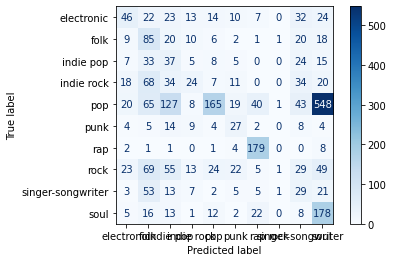

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(y_true_series, y_pred_series
                                        , cmap=plt.cm.Blues)

plt.show()

### Fold4

In [ ]:
from transformers import AutoTokenizer
import numpy as np

split0=splits[4]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
SEQ_LEN=256
print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(10832,) (2708,)
Xids_train.shape, Xids_test.shape:  (10832, 256) (2708, 256)


In [ ]:
drop_out_rate = 0.3
learning_rate_transfer_learning =1e-3
learning_rate_fine_tuning = 1e-5

In [ ]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model2 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model2.layers[2].trainable = False
#model2.summary()

#step2
optimizer = tf.keras.optimizers.Adam(learning_rate_transfer_learning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model2.compile(optimizer=optimizer, loss= loss, metrics=metrics)
#model2.summary() #Check trainable params increased.

#step3: transfer learning
print("Fine tuning---------------")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
history = model2.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])

#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy(model1, McNemar, False, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_transfer_learning.append( balanced_acc )

#step5: fine tune
model1.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(learning_rate_fine_tuning)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model2.compile(optimizer=optimizer, loss= loss, metrics=metrics)

history = model2.fit(train, validation_data=val, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])
balanced_acc, McNemar, y_predict = get_balanced_accuracy(model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )
balanced_accuracies_fine_tuning.append( balanced_acc )
print("----------------------------------------")



learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Fine tuning---------------
Epoch 1/6
609/609 [==============================] - 96s 137ms/step - loss: 2.4050 - categorical_accuracy: 0.1981 - val_loss: 2.6753 - val_categorical_accuracy: 0.0487
Epoch 2/6
609/609 [==============================] - 80s 131ms/step - loss: 2.0966 - categorical_accuracy: 0.2412 - val_loss: 2.9283 - val_categorical_accuracy: 0.0524
Epoch 3/6
609/609 [==============================] - 80s 131ms/step - loss: 2.0194 - categorical_accuracy: 0.2726 - val_loss: 2.4452 - val_categorical_accuracy: 0.1029
Epoch 4/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9638 - categorical_accuracy: 0.2809 - val_loss: 2.3145 - val_categorical_accuracy: 0.1351
Epoch 5/6
609/609 [==============================] - 79s 130ms/step - loss: 1.9288 - categorical_accuracy: 0.3021 - val_loss: 2.3298 - val_categorical_accuracy: 0.1526
Epoch 6/6
609/609 [==============================] - 80s 131ms/step - loss: 1.9171 - categorical_accuracy: 0.2927 - val_loss: 2.2486 

In [ ]:
y_pred_list = [0] * TEST_SIZE
for i, pred in enumerate(y_predict):
  y_pred_list[i] = code2genre[pred]

In [ ]:
y_true_list = []
for i, y_true in enumerate(split0['y_test']):
  y_true_list.append( code2genre[y_true] )

In [ ]:
y_pred_series = pd.Series(data = y_pred_list)
y_pred_series

In [ ]:
y_true_series = pd.Series(data = y_true_list)
y_true_series

0                     pop
1                     pop
2              electronic
3                     pop
4                     pop
              ...        
2703    singer-songwriter
2704                 soul
2705                  pop
2706                 rock
2707    singer-songwriter
Length: 2708, dtype: object

In [ ]:
y_true_series.to_csv (DIR+'RoBERTa_split4_y_true.csv')
y_pred_series.to_csv(DIR+'RoBERTa_split4_y_pred.csv')

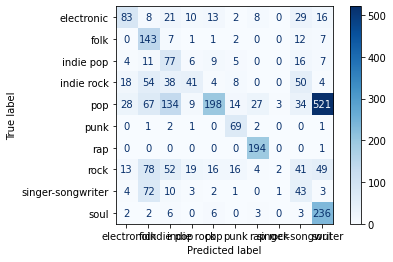

<Figure size 720x720 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true_series, y_pred_series
                                        , cmap=plt.cm.Blues)
plt.figure(figsize=(10, 10))
plt.show()

Visualize again with adjusted size

In [ ]:
y_pred_series = pd.read_csv(DIR + 'RoBERTa_split4_y_pred.csv')
y_pred_series = y_pred_series.drop(columns = ['Unnamed: 0'])
y_pred_series = y_pred_series['0']
y_pred_series

0                    soul
1               indie pop
2       singer-songwriter
3       singer-songwriter
4                    soul
              ...        
2703                 folk
2704                 soul
2705                  pop
2706            indie pop
2707    singer-songwriter
Name: 0, Length: 2708, dtype: object

In [ ]:
y_true_series = pd.read_csv(DIR + 'RoBERTa_split4_y_true.csv')
y_true_series = y_true_series.drop(columns = ['Unnamed: 0'])
y_true_series = y_true_series['0']
y_true_series

0                     pop
1                     pop
2              electronic
3                     pop
4                     pop
              ...        
2703    singer-songwriter
2704                 soul
2705                  pop
2706                 rock
2707    singer-songwriter
Name: 0, Length: 2708, dtype: object

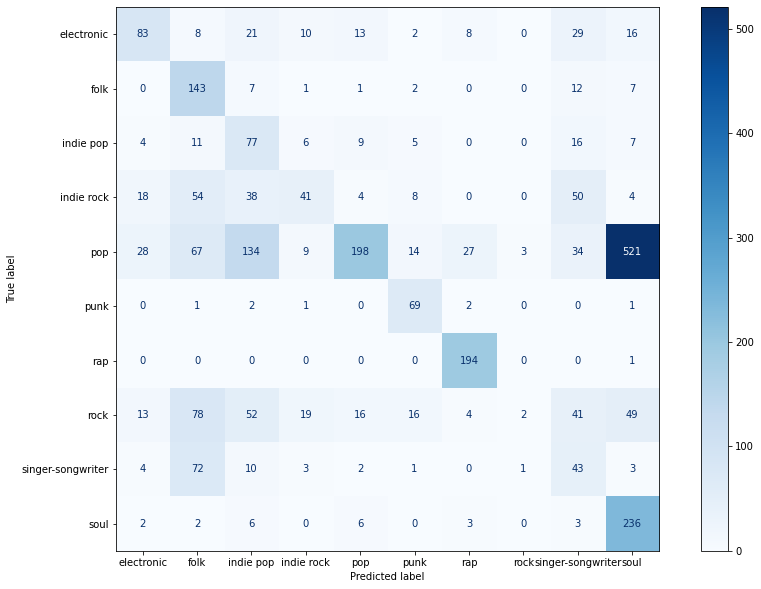

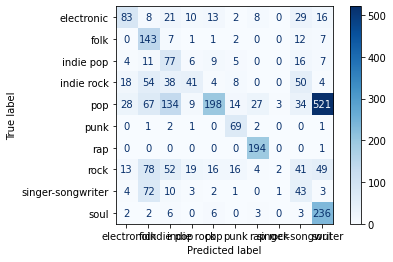

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(15,10))

cm=ConfusionMatrixDisplay.from_predictions(y_true_series, y_pred_series
                                        , cmap=plt.cm.Blues)
#plt.figure(figsize=(10, 10))
#plt.show()

cm.plot(ax=ax, cmap=plt.cm.Blues)
#plt.show()

### TSNE: visualize true labels from input embedding

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
split0['y_test']

0        4
6        4
11       0
13       4
21       4
        ..
13520    8
13528    9
13529    4
13533    7
13539    8
Name: labels, Length: 2708, dtype: int8

In [ ]:
df_true = pd.DataFrame(data = Xids_test)

In [ ]:
counter = 0
for genre in split0['y_test']:
  df_true.loc[counter, 'y'] = genre
  counter +=1

In [ ]:
df_true

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,y
0,0.0,102.0,5419.0,183.0,98.0,38.0,300.0,9261.0,7.0,7433.0,...,162.0,905.0,24.0,1895.0,905.0,24.0,1895.0,15.0,2.0,4.0
1,0.0,574.0,9596.0,62.0,3229.0,2011.0,38.0,74.0,393.0,619.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
2,0.0,713.0,16.0,99.0,38.0,216.0,20.0,34365.0,872.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,102.0,2143.0,685.0,39.0,169.0,546.0,13.0,951.0,7.0,...,561.0,101.0,1596.0,3745.0,9.0,10.0,3187.0,1144.0,2.0,4.0
4,0.0,1185.0,1656.0,88.0,5.0,929.0,407.0,1969.0,53.0,14021.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,10836.0,47.0,9202.0,127.0,10844.0,26733.0,3921.0,1801.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
2704,0.0,13624.0,38.0,2662.0,23.0,184.0,8.0,5170.0,141.0,28.0,...,374.0,127.0,652.0,374.0,127.0,652.0,45.0,25.0,2.0,9.0
2705,0.0,13368.0,1928.0,1137.0,162.0,110.0,766.0,38.0,300.0,10.0,...,183.0,376.0,419.0,1801.0,99.0,38.0,236.0,98.0,2.0,4.0
2706,0.0,565.0,9259.0,118.0,4967.0,9259.0,118.0,14223.0,9749.0,324.0,...,14223.0,9749.0,324.0,255.0,9259.0,118.0,4967.0,9259.0,2.0,7.0


In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_true.shape[0])
feat_cols = [num for num in range(256)]
print(feat_cols)
#N = 10000
df_subset = df_true.loc[rndperm,:].copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset.values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
data_subset

array([[0.0000e+00, 3.2395e+04, 5.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [0.0000e+00, 1.7790e+03, 3.8000e+01, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [0.0000e+00, 1.0000e+02, 3.1000e+02, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       ...,
       [0.0000e+00, 1.1800e+02, 6.4000e+01, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [0.0000e+00, 4.2684e+04, 1.5900e+02, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [0.0000e+00, 2.7057e+04, 3.8300e+02, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]])

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(data_subset)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.002s...
[t-SNE] Computed neighbors for 2708 samples in 0.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 18684.703820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 119.499954
[t-SNE] KL divergence after 4050 iterations: 3.287372


In [ ]:
print(tsne_results.shape)
tsne_results

(2708, 2)


array([[ 4.347622  ,  7.653019  ],
       [ 6.2934966 , -5.01658   ],
       [-4.504939  ,  1.6953483 ],
       ...,
       [-1.5654458 , -5.774189  ],
       [ 0.37266174,  7.4451103 ],
       [ 0.50155777,  4.4769597 ]], dtype=float32)

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

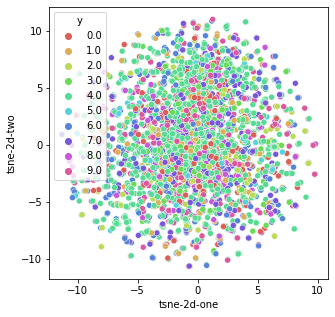

In [ ]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=1.0
)

How about train?

In [ ]:
df_train = pd.DataFrame(data = Xids_train)

In [ ]:
counter = 0
for genre in split0['y_train']:
  df_train.loc[counter, 'y'] = genre
  counter +=1

In [ ]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,y
0,0.0,35438.0,162.0,10.0,10390.0,14.0,460.0,21.0,10413.0,162.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0
1,0.0,250.0,10306.0,298.0,83.0,10306.0,298.0,370.0,439.0,7.0,...,10.0,2007.0,33301.0,141.0,1365.0,657.0,64.0,28.0,2.0,4.0
2,0.0,3341.0,10.0,1607.0,147.0,6897.0,7.0,14575.0,1534.0,24.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
3,0.0,34673.0,5.0,1617.0,38.0,1395.0,224.0,9867.0,106.0,15.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
4,0.0,100.0,21.0,1937.0,38.0,21.0,156.0,9.0,7326.0,370.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10827,0.0,11377.0,1916.0,15269.0,44831.0,2538.0,840.0,995.0,66.0,7.0,...,517.0,14597.0,1359.0,13.0,5.0,4962.0,52.0,11.0,2.0,6.0
10828,0.0,22111.0,99.0,6023.0,9.0,283.0,11.0,47.0,216.0,57.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
10829,0.0,7516.0,11380.0,11380.0,1426.0,363.0,38.0,362.0,10.0,1656.0,...,2445.0,259.0,2005.0,127.0,129.0,2813.0,42.0,76.0,2.0,4.0
10830,0.0,1121.0,282.0,1975.0,4086.0,24.0,283.0,1365.0,11.0,10.0,...,10.0,2428.0,1237.0,2131.0,8.0,2569.0,178.0,114.0,2.0,3.0


In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_train.shape[0])
feat_cols = [num for num in range(256)]
print(feat_cols)
#N = 10000
#df_subset = df_train.loc[rndperm,:].copy()
df_subset = df_train.copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset.values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
data_subset

array([[0.0000e+00, 3.5438e+04, 1.6200e+02, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [0.0000e+00, 2.5000e+02, 1.0306e+04, ..., 6.4000e+01, 2.8000e+01,
        2.0000e+00],
       [0.0000e+00, 3.3410e+03, 1.0000e+01, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       ...,
       [0.0000e+00, 7.5160e+03, 1.1380e+04, ..., 4.2000e+01, 7.6000e+01,
        2.0000e+00],
       [0.0000e+00, 1.1210e+03, 2.8200e+02, ..., 1.7800e+02, 1.1400e+02,
        2.0000e+00],
       [0.0000e+00, 3.6134e+04, 4.7000e+01, ..., 7.0000e+01, 5.0000e+00,
        2.0000e+00]])

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results = tsne.fit_transform(data_subset)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10832 samples in 0.002s...
[t-SNE] Computed neighbors for 10832 samples in 2.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10832
[t-SNE] Computed conditional probabilities for sample 2000 / 10832
[t-SNE] Computed conditional probabilities for sample 3000 / 10832
[t-SNE] Computed conditional probabilities for sample 4000 / 10832
[t-SNE] Computed conditional probabilities for sample 5000 / 10832
[t-SNE] Computed conditional probabilities for sample 6000 / 10832
[t-SNE] Computed conditional probabilities for sample 7000 / 10832
[t-SNE] Computed conditional probabilities for sample 8000 / 10832
[t-SNE] Computed conditional probabilities for sample 9000 / 10832
[t-SNE] Computed conditional probabilities for sample 10000 / 10832
[t-SNE] Computed conditional probabilities for sample 10832 / 10832
[t-SNE] Mean sigma: 16736.522279
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.958824
[t-SNE]

In [ ]:
print(tsne_results.shape)
tsne_results

(10832, 2)


array([[ -1.0368395 , -10.147692  ],
       [  0.79426146,   4.9435377 ],
       [  3.2556143 ,  -3.477712  ],
       ...,
       [  0.7247629 ,   2.6016843 ],
       [ -1.931014  ,   5.5221024 ],
       [ -2.442151  ,  -9.088748  ]], dtype=float32)

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

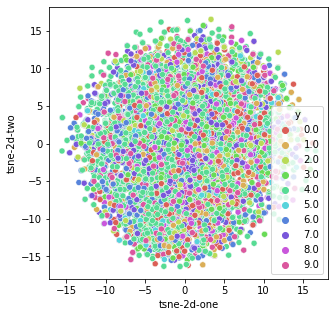

In [ ]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=1.0
)

### Use PCA first to 50 dim and then apply tSNE

In [ ]:
df_true = pd.DataFrame(data = Xids_test)

In [ ]:
counter = 0
for genre in split0['y_test']:
  df_true.loc[counter, 'y'] = genre
  counter +=1

In [ ]:
df_true

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,y
0,0.0,102.0,5419.0,183.0,98.0,38.0,300.0,9261.0,7.0,7433.0,...,162.0,905.0,24.0,1895.0,905.0,24.0,1895.0,15.0,2.0,4.0
1,0.0,574.0,9596.0,62.0,3229.0,2011.0,38.0,74.0,393.0,619.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
2,0.0,713.0,16.0,99.0,38.0,216.0,20.0,34365.0,872.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,102.0,2143.0,685.0,39.0,169.0,546.0,13.0,951.0,7.0,...,561.0,101.0,1596.0,3745.0,9.0,10.0,3187.0,1144.0,2.0,4.0
4,0.0,1185.0,1656.0,88.0,5.0,929.0,407.0,1969.0,53.0,14021.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,10836.0,47.0,9202.0,127.0,10844.0,26733.0,3921.0,1801.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
2704,0.0,13624.0,38.0,2662.0,23.0,184.0,8.0,5170.0,141.0,28.0,...,374.0,127.0,652.0,374.0,127.0,652.0,45.0,25.0,2.0,9.0
2705,0.0,13368.0,1928.0,1137.0,162.0,110.0,766.0,38.0,300.0,10.0,...,183.0,376.0,419.0,1801.0,99.0,38.0,236.0,98.0,2.0,4.0
2706,0.0,565.0,9259.0,118.0,4967.0,9259.0,118.0,14223.0,9749.0,324.0,...,14223.0,9749.0,324.0,255.0,9259.0,118.0,4967.0,9259.0,2.0,7.0


In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_true.shape[0])
feat_cols = [num for num in range(256)]
print(feat_cols)
#N = 10000
df_subset = df_true.loc[rndperm,:].copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset.values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
data_subset.shape

(2708, 256)

In [ ]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(data_subset)

for num in range(50):
  df_subset['pca-' + str(num)] = pca_result[:,num]

In [ ]:
feature_col = []
all_col = []
for num in range(50):
  feature_col.append( 'pca-' + str(num) )
  all_col.append( 'pca-' + str(num) )
feature_col

In [ ]:
all_col.append("y")

In [ ]:
df_subset[feature_col ]

,pca-0,pca-1,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7,pca-8,pca-9,...,pca-40,pca-41,pca-42,pca-43,pca-44,pca-45,pca-46,pca-47,pca-48,pca-49
1044,-1958.779960,17844.744281,-6303.507173,-2223.091856,-6053.164137,7653.144703,46.106399,9478.830589,1439.003407,8500.630760,...,1177.284642,5830.008775,6595.377753,-1109.577644,7866.901402,-14749.997801,8119.196481,893.313557,-847.432609,177.915280
439,-20775.833294,-4763.181450,6551.830757,-3973.405374,-3187.809369,15277.416631,-2688.374913,-9279.022573,918.727895,-4066.061708,...,3419.619621,-2369.306676,12525.308935,5353.550286,-7378.907308,5007.108441,3303.658916,2516.506531,-2275.905302,-1667.994254
1729,-9716.186828,-11677.990142,2082.688635,11587.628799,1545.651169,-13092.240508,-9197.621156,7965.663098,-560.802452,-4738.587135,...,2306.887743,-4816.097907,-969.644047,-8618.472571,2135.387780,2743.105282,-1079.047473,1158.621723,4569.832978,-2651.366751
296,14084.395885,7214.892310,5083.720099,-26602.377371,-2420.697205,-2986.767088,25873.886735,14189.608123,18753.953462,-19779.913671,...,-8078.461696,-8177.936074,13397.044819,20649.694482,1769.924846,-14689.101230,-9771.243412,-5212.314647,14899.725619,-8846.583606
2211,348691.733375,37890.139086,-3116.681765,-10249.962470,62513.727597,11203.493723,-44841.823311,-3167.942507,143943.166089,89350.676756,...,-3916.670622,4774.470916,29971.169158,-13049.008526,-1761.120421,6887.982293,13863.643682,15954.880707,306.932119,923.691636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,-28290.226108,-6889.920620,7994.586903,-4445.305275,6389.547469,-2098.551322,3385.909932,4469.369840,565.616832,-2522.200699,...,-1236.940100,-4579.379501,5497.499462,2778.728740,132.560555,21.746388,-501.561815,-5555.399452,-547.330030,1892.213899
1095,-10865.778026,14257.718362,-24030.234658,1879.945943,1914.509012,-2337.759124,793.909698,882.380292,781.760634,2113.374817,...,7351.333554,-761.927404,-2781.278105,5139.789457,-9718.969571,-3815.627243,2242.798274,1821.930753,6923.590381,-3041.487890
1130,-8416.032461,-9723.477377,5890.813169,1216.602906,-7316.996731,19.489691,4812.618752,3067.618159,5078.348342,7808.127729,...,5173.322113,-1747.290471,-4147.472878,-6213.071470,-4701.633252,-253.102769,4317.826768,-6339.221492,-16134.367254,1289.394815
1294,339.413876,27965.078223,-15434.592245,3871.934028,5955.432123,1176.243744,-6513.648580,1964.668347,-7647.945132,-131.124627,...,-15692.380784,-9535.843120,-3046.891812,266.553773,854.756153,2591.797000,-127.640492,-10855.353555,-5932.961997,-2379.274287


In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=700, learning_rate = 10)
tsne_results = tsne.fit_transform(df_subset[feature_col ])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.001s...
[t-SNE] Computed neighbors for 2708 samples in 0.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 14044.140496
[t-SNE] KL divergence after 50 iterations with early exaggeration: 70.410950
[t-SNE] KL divergence after 700 iterations: 2.468626


In [ ]:
print(tsne_results.shape)
tsne_results

(2708, 2)


array([[ 5.87258   , -7.573554  ],
       [-3.7415597 ,  7.747326  ],
       [-0.16783993,  1.7141436 ],
       ...,
       [ 1.0294791 ,  2.4967399 ],
       [ 9.959558  , -8.008487  ],
       [ 9.902298  , -9.941195  ]], dtype=float32)

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

In [ ]:
df_subset

,0,1,2,3,4,5,6,7,8,9,...,pca-42,pca-43,pca-44,pca-45,pca-46,pca-47,pca-48,pca-49,tsne-2d-one,tsne-2d-two
1044,0.0,32395.0,5.0,183.0,40.0,1108.0,2044.0,5021.0,40.0,185.0,...,6595.377753,-1109.577644,7866.901402,-14749.997801,8119.196481,893.313557,-847.432609,177.915280,-6.027772,-2.884994
439,0.0,1779.0,38.0,21.0,3240.0,14223.0,203.0,3240.0,87.0,452.0,...,12525.308935,5353.550286,-7378.907308,5007.108441,3303.658916,2516.506531,-2275.905302,-1667.994254,0.701254,5.673646
1729,0.0,100.0,310.0,110.0,426.0,117.0,55.0,440.0,38.0,310.0,...,-969.644047,-8618.472571,2135.387780,2743.105282,-1079.047473,1158.621723,4569.832978,-2651.366751,3.769897,-0.673878
296,0.0,17986.0,342.0,14.0,809.0,15.0,162.0,38.0,216.0,47.0,...,13397.044819,20649.694482,1769.924846,-14689.101230,-9771.243412,-5212.314647,14899.725619,-8846.583606,-9.450683,4.334514
2211,0.0,45209.0,9264.0,21402.0,1437.0,46873.0,18537.0,7487.0,48444.0,10470.0,...,29971.169158,-13049.008526,-1761.120421,6887.982293,13863.643682,15954.880707,306.932119,923.691636,5.921010,-9.600016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.0,170.0,7631.0,70.0,7238.0,84.0,481.0,1136.0,1793.0,8512.0,...,5497.499462,2778.728740,132.560555,21.746388,-501.561815,-5555.399452,-547.330030,1892.213899,-0.455998,5.507750
1095,0.0,35507.0,10.0,150.0,187.0,47.0,5324.0,38.0,619.0,101.0,...,-2781.278105,5139.789457,-9718.969571,-3815.627243,2242.798274,1821.930753,6923.590381,-3041.487890,-7.694426,-3.531948
1130,0.0,118.0,64.0,1798.0,106.0,2686.0,11.0,5.0,220.0,929.0,...,-4147.472878,-6213.071470,-4701.633252,-253.102769,4317.826768,-6339.221492,-16134.367254,1289.394815,5.081208,0.250476
1294,0.0,42684.0,159.0,30.0,110.0,14006.0,252.0,38637.0,127.0,3975.0,...,-3046.891812,266.553773,854.756153,2591.797000,-127.640492,-10855.353555,-5932.961997,-2379.274287,-9.016441,-2.969278


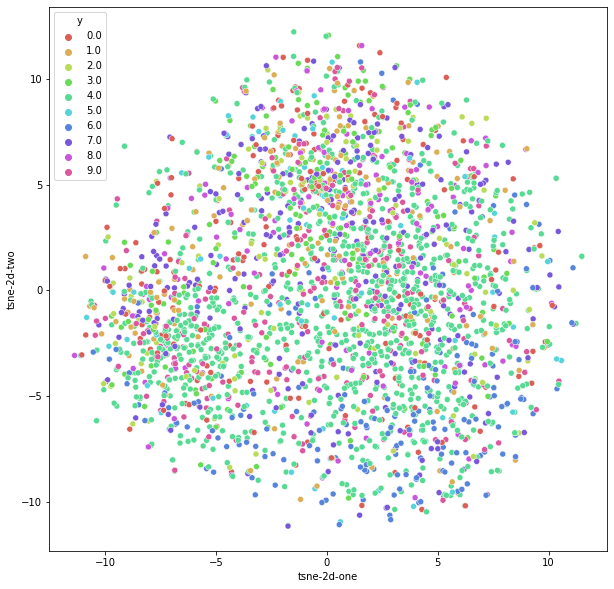

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=1.0
)